## Step 1: Setting Up the Environment

In [5]:
pip install pyasn1 httpx markdown pydantic pyjwt python-slugify tabulate werkzeug google-auth altair==4.2.1 matplotlib


Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install transformers numpy pandas scikit-learn ftfy emoji safetensors tokenizers torchvision torchaudio streamlit


Note: you may need to restart the kernel to use updated packages.


## Step 2: Data Loading and Preprocessing

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pprint import pprint

# Load the dataset
df = pd.read_csv('data/output.csv')

# Check dimension of the data
pprint(df.shape)

# Display the first few rows
pprint(df.head())

# Check columns with numerical values
pprint(df.describe())

# Check distribution of classes
pprint(df['feedback'].value_counts())

(3150, 5)
   rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1  
            rating     feedback
count  3150.000000  3150.000000
mean      4.463175     0.918413
std       1.068506     0.273778
min       1.000000     0.000000
25%       4.000000     1.000000
50%       5.000000     1.000000
75%       5.000000     1.000000
max       5.000000     1.000000
feedback
1    2893
0     257
Name: count, dtype: int64


In [8]:
# Check rating distribution for positive and negative feedback
positive_feedback_ratings = df[df['feedback'] == 1]['rating'].value_counts()
negative_feedback_ratings = df[df['feedback'] == 0]['rating'].value_counts()

pprint("Ratings distribution for positive feedback:")
pprint(positive_feedback_ratings)

pprint("Ratings distribution for negative feedback:")
pprint(negative_feedback_ratings)

'Ratings distribution for positive feedback:'
rating
5    2286
4     455
3     152
Name: count, dtype: int64
'Ratings distribution for negative feedback:'
rating
1    161
2     96
Name: count, dtype: int64


### Identifying null and empty entries

In [9]:
null_count = df['verified_reviews'].isna().sum()

# Count how many entries consist of only whitespace or are empty
empty_whitespace_count = df['verified_reviews'].str.match(r'^\s*$', na=False).sum()

# Display the counts
print(f"Number of NaN (null) entries: {null_count}")
print(f"Number of empty/whitespace-only entries: {empty_whitespace_count}")

Number of NaN (null) entries: 1
Number of empty/whitespace-only entries: 79


In [10]:
# Filter rows with null 'verified_reviews'
null_entries = df[df['verified_reviews'].isna()]

# Filter rows where 'verified_reviews' consist of only whitespace
whitespace_entries = df[df['verified_reviews'].str.match(r'^\s*$', na=False)]

# Check the distribution of 'feedback' and 'rating' for null entries
print("Distribution of feedback and rating for null entries:")
print(null_entries[['feedback', 'rating']].value_counts())

# Check the distribution of 'feedback' and 'rating' for whitespace entries
print("Distribution of feedback and rating for whitespace entries:")
print(whitespace_entries[['feedback', 'rating']].value_counts())


Distribution of feedback and rating for null entries:
feedback  rating
0         2         1
Name: count, dtype: int64
Distribution of feedback and rating for whitespace entries:
feedback  rating
1         5         40
0         1         15
1         3         12
          4          8
0         2          4
Name: count, dtype: int64


In [11]:
# Display rows where 'verified_reviews' is null
null_entries = df[df['verified_reviews'].isna()]
print("Rows with null entries in 'verified_reviews':")
print(null_entries)

# Display rows where 'verified_reviews' is null
whitespace_entries = df[df['verified_reviews'].str.match(r'^\s*$',na=False)]
pprint("Rows with whitespace entries in 'verified_reviews':")
pprint(whitespace_entries)


Rows with null entries in 'verified_reviews':
     rating       date variation verified_reviews  feedback
473       2  29-Jun-18     White              NaN         0
"Rows with whitespace entries in 'verified_reviews':"
      rating       date             variation verified_reviews  feedback
85         5  30-Jul-18  Heather Gray Fabric                           1
183        3  29-Jul-18  Heather Gray Fabric                           1
219        5  29-Jul-18     Sandstone Fabric                           1
374        1  26-Jul-18                 Black                          0
406        1  16-Jul-18                 White                          0
...      ...        ...                   ...              ...       ...
3114       3  30-Jul-18            Black  Dot                          1
3120       5  30-Jul-18            Black  Dot                          1
3123       4  30-Jul-18            Black  Dot                          1
3126       5  30-Jul-18            Black  Dot     

- Distribution Summary:
    - For null entries:
        - There's only 1 entry where feedback is 0 and rating is 2. 
        - This is a negative feedback review, and since it's only a single entry, removing it might not significantly impact the dataset.
    - For whitespace-only entries:
        - The majority of these are positive feedback with a rating of 5 (40 instances).
        - There are also negative feedback entries with ratings of 1 (15 instances) and a few positive ones with ratings of 3 and 4.

### Handling Missing and Empty Reviews

- Dropping these entries would ensure that only meaningful data is passed to the model. Since these entries don't provide any valuable text data for sentiment analysis, it might be best to remove them.
- This approach will maintain the quality of the dataset and avoid introducing any biases that could come from imputing placeholder values like "No feedback."

In [12]:
# Remove rows with NaN (null) in 'verified_reviews'
df = df.dropna(subset=['verified_reviews'])

# Remove rows where 'verified_reviews' consist of only whitespace
df = df[~df['verified_reviews'].str.match(r'^\s*$', na=False)]

# Check the new shape of the dataset after removing these entries
print(f"New dataset shape after removing null and whitespace entries: {df.shape}")


New dataset shape after removing null and whitespace entries: (3070, 5)


### Identifying the non-ascii entries 

In [13]:
non_ascii_count = df['verified_reviews'].str.contains(r'[^\x00-\x7F]', na=False).sum()
print(f"Number of non-ascii entries: {non_ascii_count}")
total_entries = df['verified_reviews'].count()
percentage_non_ascii_count = non_ascii_count/total_entries

print(f"percentage of non-ascii entry: {(round(percentage_non_ascii_count,2))*100}%")

Number of non-ascii entries: 338
percentage of non-ascii entry: 11.0%


### Identifying and Counting Entries with Emojis

In [14]:
import re
# Define a regex pattern that matches emojis
emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F700-\U0001F77F"  # alchemical symbols
    u"\U0001F780-\U0001F7FF"  # geometric shapes
    u"\U0001F800-\U0001F8FF"  # supplemental arrows
    u"\U0001F900-\U0001F9FF"  # supplemental symbols & pictographs
    u"\U0001FA00-\U0001FA6F"  # chess symbols
    u"\U0001FA70-\U0001FAFF"  # supplemental pictographs
    u"\U00002700-\U000027BF"  # Dingbats
    u"\U0001F1E0-\U0001F1FF"  # Flags
    u"\U00000280-\U0000029F"  # Braille Patterns (sometimes present in encoded text)
    u"\U00002500-\U0000257F"  # Box Drawing (lines and shapes)
    u"\U0001F910-\U0001F91F"  # Supplemental Symbols and pictographs (hand gestures)
    u"\U0001F600-\U0001F64F"  # Additional emoticons (for newer emojis)
    u"\U0001FA70-\U0001FAFF"  # Symbols and pictographs
    u"\U0001F6C0-\U0001F6FF"  # Transport and map symbols
    u"\U00002B50-\U00002B55"  # Additional symbols (stars, etc.)
    u"\U00002600-\U000027BF"  # Miscellaneous Symbols
   "]+", flags=re.UNICODE)

# Identify entries containing emojis
emoji_entries = df[df['verified_reviews'].str.contains(emoji_pattern, na=False)]

# Count the number of entries with emojis
emoji_count = len(emoji_entries)

# Display the count and a few examples of entries with emojis
print(f"Number of entries containing emojis: {emoji_count}")
pprint(emoji_entries)

Number of entries containing emojis: 29
      rating       date                     variation  \
49         3  30-Jul-18              Charcoal Fabric    
60         5  30-Jul-18          Heather Gray Fabric    
134        5  30-Jul-18              Charcoal Fabric    
229        5  29-Jul-18              Charcoal Fabric    
447        5  05-Jul-18                         Black   
541        5  16-Jun-18                         White   
681        3  19-May-18                         Black   
744        3  30-Jul-18              Charcoal Fabric    
755        5  30-Jul-18          Heather Gray Fabric    
829        5  30-Jul-18              Charcoal Fabric    
924        5  29-Jul-18              Charcoal Fabric    
1101       4  30-Jul-18                   Black  Spot   
1160       5  29-Jul-18                   Black  Spot   
1237       5  26-Jul-18                   Black  Spot   
1238       5  26-Jul-18                   Black  Spot   
1351       4  19-Jul-18                   White 

### Cleaning Non-ASCII Characters While Keeping Emojis

In [15]:
import ftfy
# Function to clean non-ASCII characters while keeping emojis
def clean_non_ascii_keep_emojis(text):
    if pd.notnull(text):
        # Step 1: Keep emojis and remove non-ASCII characters using the regex
        emojis = emoji_pattern.findall(text)
        
        # Step 2: Fix encoding issues in the text using ftfy
        cleaned_text = ftfy.fix_text(text)
        
        # Step 3: Remove non-ASCII characters (excluding emojis)
        cleaned_text_no_nonascii = re.sub(r'[^\x00-\x7F]+', '', cleaned_text)
        
        # Step 4: Re-add emojis at the end if they were removed
        return cleaned_text_no_nonascii + ' ' + ''.join(emojis) if emojis else cleaned_text_no_nonascii
    return text

# Apply the cleaning function to the 'verified_reviews' column
df['verified_reviews'] = df['verified_reviews'].apply(clean_non_ascii_keep_emojis)

# Display cleaned entries
print(df['verified_reviews'].head())

0                                        Love my Echo!
1                                            Loved it!
2    Sometimes while playing a game, you can answer...
3    I have had a lot of fun with this thing. My 4 ...
4                                                Music
Name: verified_reviews, dtype: object


In [16]:
non_ascii_count = df['verified_reviews'].str.contains(r'[^\x00-\x7F]', na=False).sum()
print(f"Number of non-ascii entries: {non_ascii_count}")

df.shape

Number of non-ascii entries: 29


(3070, 5)

In [17]:
import re

# Identify reviews containing emojis
emoji_entries = df[df['verified_reviews'].str.contains(emoji_pattern, na=False)]

# Calculate the percentage of reviews containing emojis
emoji_percentage = len(emoji_entries) / len(df) * 100
print(f"Percentage of reviews containing emojis: {emoji_percentage:.2f}%")

# Check how many reviews contain emojis
print(f"Number of reviews containing emojis: {len(emoji_entries)}")


Percentage of reviews containing emojis: 0.94%
Number of reviews containing emojis: 29


Even though the percentage of emoji usage is low, emojis can still carry strong emotional cues (like "😍" indicating positive sentiment or "😒" indicating negative sentiment). These cues are important in interpreting feedback, especially in cases where the text alone might not fully convey the sentiment (e.g., sarcasm or humor).

Given this, converting emojis to text descriptions could still be helpful for sentiment interpretation, even though they are infrequent. By converting them, you're making the emotional intent of the review more explicit, which could help the model better understand the feedback.

### Converting Emojis to Text Descriptions

In [18]:
import emoji

# Convert emojis to their textual descriptions
def convert_emoji_to_text(text):
    if isinstance(text, str):  # Only process if the input is a string
        return emoji.demojize(text)
    return text  # Return the original value if it's not a string

In [19]:
# Example: Apply to the 'verified_reviews' column
df['verified_reviews'] = df['verified_reviews'].apply(lambda x: convert_emoji_to_text(x))

# Check a few entries
df['verified_reviews']


0                                           Love my Echo!
1                                               Loved it!
2       Sometimes while playing a game, you can answer...
3       I have had a lot of fun with this thing. My 4 ...
4                                                   Music
                              ...                        
3145    Perfect for kids, adults and everyone in betwe...
3146    Listening to music, searching locations, check...
3147    I do love these things, i have them running my...
3148    Only complaint I have is that the sound qualit...
3149                                                 Good
Name: verified_reviews, Length: 3070, dtype: object

In [20]:
non_ascii_count = df['verified_reviews'].str.contains(r'[^\x00-\x7F]', na=False).sum()
print(f"Number of non-ascii entries: {non_ascii_count}")

ver_review=df['verified_reviews'].head()

pprint(ver_review)

Number of non-ascii entries: 0
0                                        Love my Echo!
1                                            Loved it!
2    Sometimes while playing a game, you can answer...
3    I have had a lot of fun with this thing. My 4 ...
4                                                Music
Name: verified_reviews, dtype: object


### Splitting Data into Training and Testing Sets

In this step, we extract the relevant columns containing the reviews and feedback (labels), and split the data into training and test sets using an 80-20 split. 
The training set will be used to fit the model, while the test set will be used for evaluation.
We also check the distribution of feedback labels to understand the balance between positive and negative reviews.

In [21]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Further split the test data into validation (10%) and test sets (10%)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Extract texts and labels for training, validation, and test sets
train_texts = [str(text) for text in train_data['verified_reviews'] if isinstance(text, str)]
val_texts = [str(text) for text in val_data['verified_reviews'] if isinstance(text, str)]
test_texts = [str(text) for text in test_data['verified_reviews'] if isinstance(text, str)]

# Extract labels (feedback) for training, validation, and test sets
train_labels = train_data['feedback'].tolist()
val_labels = val_data['feedback'].tolist()
test_labels = test_data['feedback'].tolist()

# Check sizes to ensure labels and texts match
print(f"Training set: {len(train_texts)} texts, {len(train_labels)} labels")
print(f"Validation set: {len(val_texts)} texts, {len(val_labels)} labels")
print(f"Test set: {len(test_texts)} texts, {len(test_labels)} labels")


Training set: 2456 texts, 2456 labels
Validation set: 307 texts, 307 labels
Test set: 307 texts, 307 labels


## Step 3: Tokenization with BERT

Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


Mean token length: 33.62907166123779
Max token length: 637
Min token length: 3


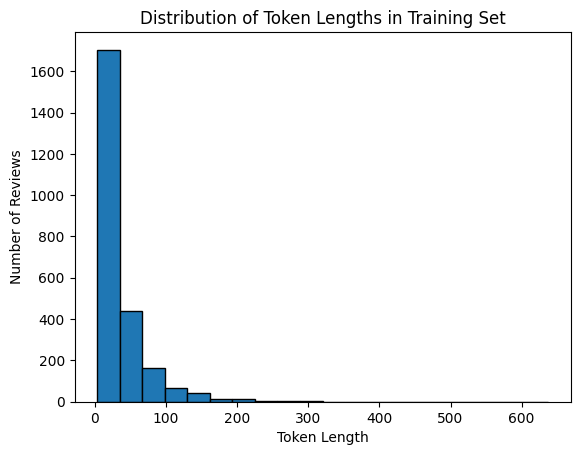

In [22]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Clean the text to ensure all values are strings
train_texts = [str(text) for text in train_data['verified_reviews'] if isinstance(text, str)]
val_texts = [str(text) for text in val_data['verified_reviews'] if isinstance(text, str)]
test_texts = [str(text) for text in test_data['verified_reviews'] if isinstance(text, str)]

# Tokenize without padding and truncation, and do not return tensors
def tokenize_and_get_lengths(texts):
    tokenized_outputs = tokenizer(
        texts,
        padding=False,        # Do not pad the sequences
        truncation=False,     # Do not truncate the sequences
        return_tensors=None,  # Do not return tensors; we only need raw token lengths
        max_length=None       # Allow sequences to take their natural length
    )
    return [len(tokens) for tokens in tokenized_outputs['input_ids']]

# Get the token lengths for the training set
train_lengths = tokenize_and_get_lengths(train_texts)

# Check the statistics (e.g., mean, max, min) of token lengths
import numpy as np
print(f"Mean token length: {np.mean(train_lengths)}")
print(f"Max token length: {np.max(train_lengths)}")
print(f"Min token length: {np.min(train_lengths)}")

# Optionally, plot the distribution of token lengths
import matplotlib.pyplot as plt

plt.hist(train_lengths, bins=20, edgecolor='black')
plt.title('Distribution of Token Lengths in Training Set')
plt.xlabel('Token Length')
plt.ylabel('Number of Reviews')
plt.show()


In [24]:
# Set max_length based on analysis (e.g., 100 or 128)
max_length = 100  # Adjust this if needed

# Identify reviews longer than 512 tokens
def tokenize_and_get_lengths(texts):
    tokenized_outputs = tokenizer(
        texts,
        padding=False,
        truncation=False,
        return_tensors=None,
        max_length=None
    )
    return [len(tokens) for tokens in tokenized_outputs['input_ids']]

# Get token lengths for the training set
train_lengths = tokenize_and_get_lengths(train_texts)

# Filter out reviews longer than 512 tokens and their corresponding labels
filtered_data = [(text, label) for text, length, label in zip(train_texts, train_lengths, train_labels) if length <= 512]

# Separate the filtered texts and labels
train_data_filtered, train_labels_filtered = zip(*filtered_data)

# Proceed with tokenization using max_length = 100 for the filtered data
train_encodings = tokenizer(
    list(train_data_filtered),  # Convert back to a list
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=max_length
)

val_encodings = tokenizer(
    val_texts,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=max_length
)

test_encodings = tokenizer(
    test_texts,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=max_length
)

# Check if the number of tokenized inputs matches the number of filtered labels
print(f"Number of tokenized inputs: {len(train_encodings['input_ids'])}")
print(f"Number of labels: {len(train_labels_filtered)}")


Number of tokenized inputs: 2454
Number of labels: 2454


## Step 4: Fine-Tuning BERT for Sentiment Analysis

### Load Pre-Trained BERT Model

In [25]:
import torch
from transformers import BertForSequenceClassification
from torch.optim import AdamW
import pandas as pd  # For checking missing values

# Load pre-trained BERT model for binary classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Prepare Data (Already Tokenized in Step 3)

In [26]:

# PyTorch Dataset class to handle tokenized encodings and labels
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)  # Ensure this matches the number of tokenized inputs

    def __getitem__(self, idx):
        if idx >= len(self.labels):  # Protect against out-of-bound access
            raise IndexError(f"Index {idx} is out of bounds with size {len(self.labels)}")
        
        # Return the tokenized inputs and the labels at index `idx`
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


# Ensure filtered labels are used for the training dataset
train_dataset = ReviewDataset(train_encodings, list(train_labels_filtered))  # Use filtered labels
test_dataset = ReviewDataset(test_encodings, test_labels)  # No filtering for test

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Check if the number of tokenized inputs matches the number of filtered labels
print(f"Number of tokenized inputs: {len(train_encodings['input_ids'])}")
print(f"Number of labels (filtered): {len(train_labels_filtered)}")


Number of tokenized inputs: 2454
Number of labels (filtered): 2454


### Calculate class weights

In [32]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Convert the class labels to a numpy array
classes = np.array([0, 1])

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)

# Convert class weights to a tensor and move to device (GPU or CPU)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)



### Set Up the Optimizer

In [33]:
from torch.optim import AdamW

# Define the optimizer with learning rate and weight decay
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)


## Step 5: Training the Model

In [36]:
from tqdm import tqdm  # For progress bar during training

def train(model, train_loader, optimizer, device, class_weights):
    model.train()  # Set the model to training mode
    total_loss = 0
    
    for batch in tqdm(train_loader):
        # Move inputs and labels to device (GPU or CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass to get model outputs and calculate loss
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Apply class weights to the loss
        weighted_loss = loss * class_weights[labels]
        loss = weighted_loss.mean()  # Compute average loss

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update model parameters

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Average training loss with class weighting: {avg_loss:.4f}")

# Fine-tune for a few epochs
num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model, train_loader, optimizer, device, class_weights)


Epoch 1/3


100%|██████████| 154/154 [09:34<00:00,  3.73s/it]


Average training loss with class weighting: 0.2492
Epoch 2/3


100%|██████████| 154/154 [10:15<00:00,  3.99s/it]


Average training loss with class weighting: 0.1057
Epoch 3/3


100%|██████████| 154/154 [10:11<00:00,  3.97s/it]

Average training loss with class weighting: 0.0561


## Step 6: Evaluating the model 

In [37]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch in test_loader:
            # Move inputs to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass to get predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Evaluate the model on the test set
evaluate(model, test_loader, device)


Accuracy: 0.9577
F1 Score: 0.9775


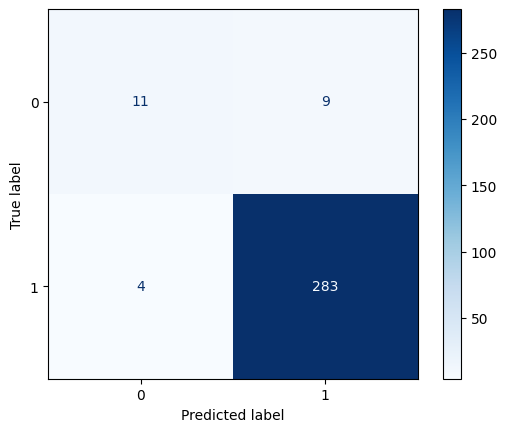

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch in test_loader:
            # Move inputs to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass to get predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(model, test_loader, device)


In [39]:
# Save the trained model
model.save_pretrained('./bert_sentiment_model_v1')


In [40]:
tokenizer.save_pretrained('./bert_sentiment_tokeniser_v1')

('./bert_sentiment_tokeniser_v1\\tokenizer_config.json',
 './bert_sentiment_tokeniser_v1\\special_tokens_map.json',
 './bert_sentiment_tokeniser_v1\\vocab.txt',
 './bert_sentiment_tokeniser_v1\\added_tokens.json')

In [43]:
import emoji
import torch
from transformers import BertForSequenceClassification, BertTokenizer

# Load the saved model
model = BertForSequenceClassification.from_pretrained('./bert_sentiment_model_v1')
model.eval()

# Load the saved tokenizer
tokenizer = BertTokenizer.from_pretrained('./bert_sentiment_tokeniser_v1')

# Tokenize new input data
new_texts = [
    #positive reviews
    "I love this product!",
    "This is awesome",
    
    #negative reviews
    "Not happy with the product.",
    "Not happy with it.",

    # Negation
    "Not happy with the service.",  
    "This is not what I expected.",  
    "Not happy with the color.",
    "Not happy with service but product is good",
    
    # Mixed sentiment
    "The product is great, but the packaging was terrible.",
    "I loved the features, but it's way too expensive.",


    # Slang and informal
    "This product is lit! 🔥",  
    "It's dope, can't get enough of it.",
    "This is  :fire:",
    "This is GOAT🐐",
    "I feel its damn good",
    "bad boy song is sounding dope on this :thumbs_up:",
    "bad boy song is sounding like samsh hit on this",
    
    # Neutral
    "The product arrived on time.",  
    "It's just okay, nothing special."
      
    # Sarcastic reviews
    "Yeah, because everyone loves waiting 2 weeks for a delivery...",
    "What a innovative product..Thank you amazon for such a good product which doesnt work."
]

reviews_with_emoji_desc = [emoji.demojize(text) for text in new_texts]
new_encodings = tokenizer(reviews_with_emoji_desc, padding=True, truncation=True, return_tensors='pt', max_length=128)

# Run the model for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
new_encodings = {key: val.to(device) for key, val in new_encodings.items()}

with torch.no_grad():
    outputs = model(**new_encodings)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Convert predictions to sentiment labels
predicted_labels = ['positive' if pred == 1 else 'negative' for pred in predictions]

# Display the results
for text, label in zip(reviews_with_emoji_desc, predicted_labels):
    print(f"Text: \"{text}\"")
    print(f"Predicted sentiment: {label}")
    print()


Text: "I love this product!"
Predicted sentiment: positive

Text: "This is awesome"
Predicted sentiment: positive

Text: "Not happy with the product."
Predicted sentiment: positive

Text: "Not happy with it."
Predicted sentiment: negative

Text: "Not happy with the service."
Predicted sentiment: positive

Text: "This is not what I expected."
Predicted sentiment: negative

Text: "Not happy with the color."
Predicted sentiment: positive

Text: "Not happy with service but product is good"
Predicted sentiment: positive

Text: "The product is great, but the packaging was terrible."
Predicted sentiment: negative

Text: "I loved the features, but it's way too expensive."
Predicted sentiment: positive

Text: "This product is lit! :fire:"
Predicted sentiment: positive

Text: "It's dope, can't get enough of it."
Predicted sentiment: positive

Text: "This is  :fire:"
Predicted sentiment: positive

Text: "This is GOAT:goat:"
Predicted sentiment: positive

Text: "I feel its damn good"
Predicted sen

In [44]:
# Convert train_texts and train_labels to lists, so they can be modified
train_texts = list(train_texts)
train_labels = list(train_labels)

# Augment the dataset with negation examples
negation_sentences = [
    "I am not happy with the service.",
    "This is not what I expected.",
    "The product didn’t meet my expectations.",
    "I don't like this at all.",
    "The service wasn’t good.",
]

# Add these negation examples to your training data
train_texts.extend(negation_sentences)
train_labels.extend([0] * len(negation_sentences))  # Assign negative labels (0)


In [45]:
# Augment the dataset with mixed sentiment examples
mixed_sentiment_sentences = [
    "The product works well, but the customer support is terrible.",
    "I loved the design, but the material is cheap.",
    "Great functionality, but too expensive.",
]

# Add these mixed sentiment examples to your training data
train_texts.extend(mixed_sentiment_sentences)
train_labels.extend([0] * len(mixed_sentiment_sentences))  # Assign negative labels or label as mixed


In [46]:
# Augment the dataset with slang examples
slang_sentences = [
    "This product is dope!",
    "The new feature is lit!",
    "That song is fire!",
]

# Add these slang examples to your training data
train_texts.extend(slang_sentences)
train_labels.extend([1] * len(slang_sentences))  # Assign positive labels


In [47]:
# Convert train_texts and train_labels to lists if they are tuples
train_texts = list(train_texts)
train_labels = list(train_labels)

# Augment the dataset with sarcastic reviews
sarcastic_reviews = [
    "Oh wow, this is the best product ever... not!",  # Positive-sounding, but negative sentiment
    "Just what I needed, a broken item!",            # Ironic, implying dissatisfaction
    "Yeah, because everyone loves waiting 2 weeks for a delivery...",  # Sarcastic negative review
    "Oh great, it stopped working after one use. Fantastic.",  # Sarcasm
    "Sure, this product is amazing if you like wasting money.",  # Sarcastic and negative
    "Wow, I'm so impressed that it broke the second I touched it.",  # Sarcasm
]

# Add these sarcastic examples to your training data
train_texts.extend(sarcastic_reviews)
train_labels.extend([0] * len(sarcastic_reviews))  # Assign negative labels (0)


In [48]:
def convert_emojis_to_text(text):
    return emoji.demojize(text)

In [49]:
sarcastic_reviews_with_positive_emojis = [
    "Oh wow, this product is amazing... 😂",        # Sarcastic with laughing emoji
    "Love how it broke in one day 😂",              # Sarcastic with laughing emoji
    "Best service ever... not! 😊",                 # Sarcastic with smiling emoji
    "Yeah, because everyone loves a broken item 😍", # Sarcastic with heart-eyes emoji
    "Just fantastic, it stopped working immediately 😄", # Sarcastic with happy emoji
    "This is the best waste of money I've ever had 😊", # Sarcastic with smiling emoji
    "I'm so impressed with how terrible this is 😂", # Sarcastic with laughing emoji
]

# Convert emojis to their text descriptions
sarcastic_reviews_with_converted_emojis = [convert_emojis_to_text(review) for review in sarcastic_reviews_with_positive_emojis]

# Add these converted sarcastic examples to your training data
train_texts.extend(sarcastic_reviews_with_converted_emojis)
train_labels.extend([0] * len(sarcastic_reviews_with_converted_emojis))  # Assign negative labels (0)

# Print out the sarcastic examples with converted emojis
print("Added sarcastic reviews with emojis converted to text:")
for text, label in zip(sarcastic_reviews_with_converted_emojis, [0] * len(sarcastic_reviews_with_converted_emojis)):
    print(f"Review: {text}, Label: {label}")

Added sarcastic reviews with emojis converted to text:
Review: Oh wow, this product is amazing... :face_with_tears_of_joy:, Label: 0
Review: Love how it broke in one day :face_with_tears_of_joy:, Label: 0
Review: Best service ever... not! :smiling_face_with_smiling_eyes:, Label: 0
Review: Yeah, because everyone loves a broken item :smiling_face_with_heart-eyes:, Label: 0
Review: Just fantastic, it stopped working immediately :grinning_face_with_smiling_eyes:, Label: 0
Review: This is the best waste of money I've ever had :smiling_face_with_smiling_eyes:, Label: 0
Review: I'm so impressed with how terrible this is :face_with_tears_of_joy:, Label: 0


In [54]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load the saved model
model = BertForSequenceClassification.from_pretrained('./bert_sentiment_model_v1')

# Load the saved tokenizer
tokenizer = BertTokenizer.from_pretrained('./bert_sentiment_model_v1')

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [57]:
from torch.optim import AdamW  # Use the PyTorch AdamW optimizer

# Tokenize the expanded dataset
train_encodings = tokenizer(train_texts, padding=True, truncation=True, return_tensors='pt', max_length=128)

# Convert labels to tensor
train_labels = torch.tensor(train_labels)

# PyTorch Dataset class to handle tokenized encodings and labels
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Fixed the issue here
        return item


# Create the dataset and DataLoader
train_dataset = ReviewDataset(train_encodings, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

# Compute class weights if the dataset is imbalanced
classes = torch.unique(train_labels).numpy()  # [0, 1]
class_weights = compute_class_weight('balanced', classes=classes, y=train_labels.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the optimizer with PyTorch's AdamW
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function with class weighting
def train(model, train_loader, optimizer, device, class_weights):
    model.train()  # Set the model to training mode
    total_loss = 0
    
    for batch in tqdm(train_loader):
        # Move inputs and labels to device (GPU or CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass to get model outputs and calculate loss
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Apply class weights to the loss
        weighted_loss = loss * class_weights[labels]
        loss = weighted_loss.mean()  # Compute average loss

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update model parameters

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Average training loss with class weighting: {avg_loss:.4f}")

# Fine-tune for a few epochs
num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model, train_loader, optimizer, device, class_weights)



C:\Users\amey9\AppData\Local\Temp\ipykernel_6664\1151776240.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)


Epoch 1/3


100%|██████████| 155/155 [13:22<00:00,  5.18s/it]


Average training loss with class weighting: 0.0303
Epoch 2/3


100%|██████████| 155/155 [13:43<00:00,  5.31s/it]


Average training loss with class weighting: 0.0133
Epoch 3/3


100%|██████████| 155/155 [12:57<00:00,  5.02s/it]

Average training loss with class weighting: 0.0101


In [58]:
# Save the fine-tuned model and tokenizer
model.save_pretrained('./bert_sentiment_v2')
tokenizer.save_pretrained('./bert_sentiment_tokenizer_v2')

('./bert_sentiment_tokenizer_v2\\tokenizer_config.json',
 './bert_sentiment_tokenizer_v2\\special_tokens_map.json',
 './bert_sentiment_tokenizer_v2\\vocab.txt',
 './bert_sentiment_tokenizer_v2\\added_tokens.json')

In [63]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer

# Load the fine-tuned model
model = BertForSequenceClassification.from_pretrained('./bert_sentiment_v2')
model.to(device)  # Move model to GPU or CPU

# Load the saved tokenizer
tokenizer = BertTokenizer.from_pretrained('./bert_sentiment_tokenizer_v2')

In [64]:
# Tokenize the test data
test_encodings = tokenizer(test_texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Fixed the issue here
        return item

# Create test dataset and loader
test_dataset = ReviewDataset(test_encodings, test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Move model to evaluation mode
model.eval()

# Evaluate on test data
correct = 0
total = 0
predictions = []
labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label_ids = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)
        
        correct += (preds == label_ids).sum().item()
        total += label_ids.size(0)
        
        predictions.extend(preds.cpu().numpy())
        labels.extend(label_ids.cpu().numpy())

# Calculate accuracy
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

# Optionally, calculate F1 score, precision, recall, confusion matrix
from sklearn.metrics import f1_score, confusion_matrix, classification_report

print("F1 Score:", f1_score(labels, predictions))
print("Confusion Matrix:\n", confusion_matrix(labels, predictions))
print("Classification Report:\n", classification_report(labels, predictions))


Test Accuracy: 0.9577
F1 Score: 0.9775474956822107
Confusion Matrix:
 [[ 11   9]
 [  4 283]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.55      0.63        20
           1       0.97      0.99      0.98       287

    accuracy                           0.96       307
   macro avg       0.85      0.77      0.80       307
weighted avg       0.95      0.96      0.95       307

